# TP 2 - Séance 2
## Apprentissage profond appliqué aux images médicales

Équipe #22
- Beaudry, Sophie (2140839)
- Lachapelle, Vincent (2206192)

Ces deux classes déla présence ou l'absence de tissus cancéreux. elles sont représentées par soit un 0 soit un 1.

In [3]:
import gc
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset, disable_caching
from pcam_utils import get_dataloaders, get_model_and_optimizer, train_epoch, validate
from tqdm.auto import tqdm  # Pour faire des jolies barres de progression


disable_caching()  # Ne modifiez pas cette ligne!

# Exercice III : Classification d'images histologiques

Le jeu de données `dataset` est un objet de type [`DatasetDict`](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.DatasetDict) organisé comme un `dict` standard en Python, avec des entrées nommées `"train"`, `"validation"`, et `"test"` et qui contiennent des [`Dataset`](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset) - qui eux contiennent les images et leur label associé.

Vous pouvez interagir avec un `DatasetDict` essentiellement de la même manière qu'avec un `dict` (e.g. les méthodes `keys()`/`values()`/`items()`, aller chercher une entrée avec la notation par crochets `dataset["train"]`, etc.).

Pour interagir avec un `Dataset`, vous pouvez soit aller chercher un exemple donné (e.g. `dataset["train"][0]` qui est un `dict` qui contient une image et son label), soit aller chercher **tous** les labels/images du dataset (e.g. `dataset["train"]["label"]`).

<span style="color:red">**Attention!** Si vous essayez de charger toutes les images d'un coup, ça ne machera probablement pas car il y en a beaucoup trop pour la quantité de RAM qui est vraisemblablement disponible sur votre machine.
</span>

In [4]:
# Ne modifiez pas cette cellule!
dataset = load_dataset("zacharielegault/PatchCamelyon")

## Exploration des données
**Q1**. Combien d'images y a-t-il dans chaque sous-ensemble du dataset?

In [5]:
lengths = {key: len(dataset[key]) for key in dataset.keys()}

for key in dataset.keys():
    print(f"La taille du sous-ensemble '{key}' est de {lengths[key]} images.")

La taille du sous-ensemble 'train' est de 262144 images.
La taille du sous-ensemble 'validation' est de 32768 images.
La taille du sous-ensemble 'test' est de 32768 images.


**Q2**. Quelles sont les classes représentées dans le dataset? Comment sont-elles représentées?

In [7]:
print(f"Les deux classes sont : {np.unique(dataset["train"]["label"])}.")

Les deux classes sont : [0 1].


Ces deux classes décrivent la présence ou l'absence de tissus cancéreux. elles sont représentées par un 1 ou un 0 respectivement.

**Q3**. Quel nombre et proportion des images de chaque sous-ensemble appartient aux différentes classes? Affichez un histogramme de la distribution des classes pour chaque sous-ensemble.

N.B.: Vous pouvez utiliser l'argument `edgecolor="black"` (e.g. `plt.hist(..., edgecolor="black")` ou `ax.hist(..., edgecolor="black")`) pour tracer une ligne noire autour des bandes de votre histogramme. Ceci pourrait rendre la lecture des histogrammes plus facile.


La proportion de la classe 0 dans l'ensemble train est de 0.5000, alors que celle de la classe 1 est de 0.5000.
La proportion de la classe 0 dans l'ensemble validation est de 0.5005, alors que celle de la classe 1 est de 0.4995.
La proportion de la classe 0 dans l'ensemble test est de 0.5002, alors que celle de la classe 1 est de 0.4998.


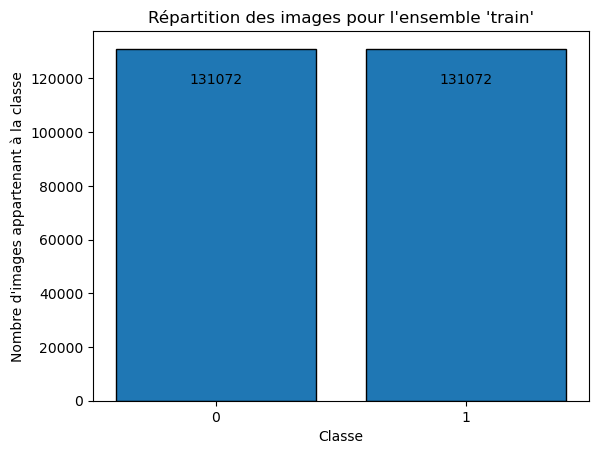

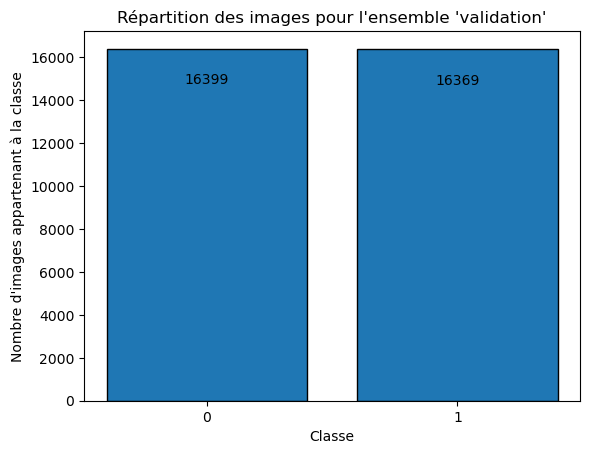

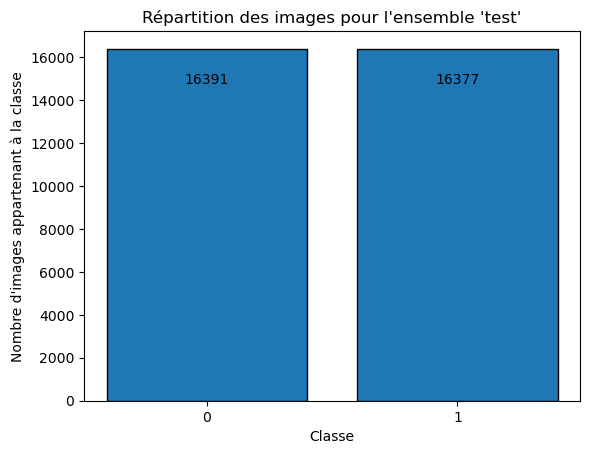

In [9]:
for key in dataset.keys():
    unique, counts = np.unique(dataset[key]["label"], return_counts=True)
    fig, ax = plt.subplots(1,1)
    ax.bar([0, 1], counts, edgecolor='black')
    ax.set_title(f"Répartition des images pour l'ensemble '{key}'")
    ax.set_xlabel("Classe")
    ax.set_ylabel("Nombre d'images appartenant à la classe")
    ax.set_xticks(range(len(unique)), unique)
    for i, count in enumerate(counts):
        ax.text(i, count * 0.9, f"{count}", horizontalalignment='center')
    
    print(f"La proportion de la classe 0 dans l'ensemble {key} est de {counts[0]/sum(counts):.4f}, alors que celle de la classe 1 est de {counts[1]/sum(counts):.4f}.")

**Q4**. Affichez un échantillon de l'ensemble d'entraînement. Assurez vous que votre échantillon contienne au moins 2 images de chaque classe. Affichez l'indice et la classe de chaque image.

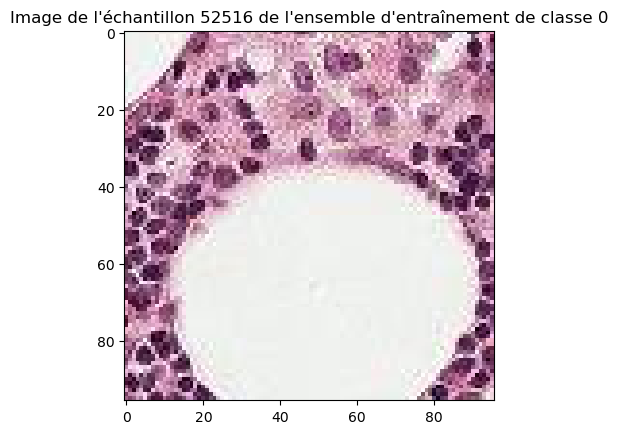

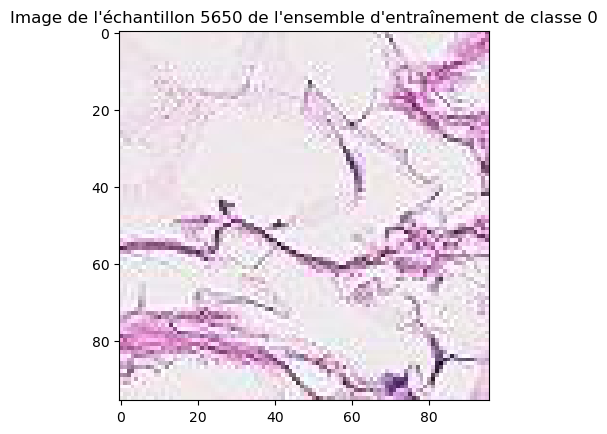

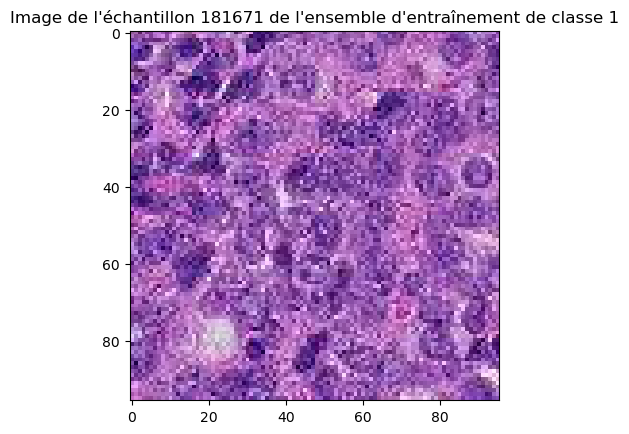

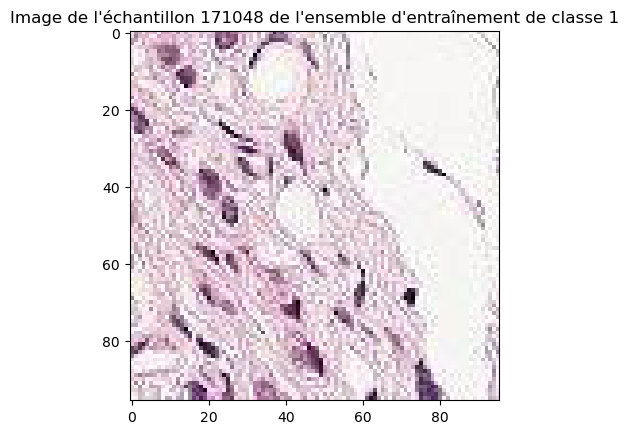

In [10]:
indexes_by_class = {0: [], 1: []}

for index, label in enumerate(dataset["train"]["label"]):
    indexes_by_class[label].append(index)

echantillon_0 = np.random.choice(indexes_by_class[0], size=2, replace=False).tolist()
echantillon_1 = np.random.choice(indexes_by_class[1], size=2, replace=False).tolist()

echantillons = echantillon_0 + echantillon_1
echantillons = [(index, dataset["train"]["image"][index], dataset["train"]["label"][index]) for index in echantillons]

for index, image, label in echantillons:
    fig, ax = plt.subplots(1,1)

    ax.set_title(f"Image de l'échantillon {index} de l'ensemble d'entraînement de classe {label}")
    ax.imshow(image)


Nous avons laissé ces images en couleurs, car les modèles entraînés utilisent l'information de tous les canaux pour établir leur prédiction.

## Petite note sur les fonctions fournies

### `get_model_and_optimizer`
Crée un modèle et son optimiseur. Cette fonction prend 2 arguments: un float `lr` (le taux d'apprentissage ou *learning rate*) et un booléen optionnel `pretrained` (pour indiquer si le modèle a été pré-entraîné sur l'ensemble [ImageNet](https://en.wikipedia.org/wiki/ImageNet) ou s'il a été initialisé aléatoirement).

### `get_dataloaders`
Crée trois dataloaders (qui permettent d'itérer sur un dataset et qui devront être passées à `train_epoch` et `validate`) -- un pour chaque sous-ensemble (entraînement, validation, test). Cette fonction attend deux argument obligatoires: un `DatasetDict` (le dataset qu'on a créé plus haut) et un entier `batch_size` (qui détermine combien d'exemples le modèle traitera à chaque itération).

Quelques notes additionnelles sur cette fonction:
1. En général, il est préférable d'utiliser la plus grande *batch size* possible qui entre en mémoire sur votre GPU. Vous pouvez expérimenter avec différentes valeurs (typiquement par puissances de 2) jusqu'à ce que vous trouviez une valeur qui fonctionne, mais une *batch size* de 128 devrait être suffisante et entrer en mémoire de la plupart des GPU.
2. La fonction offre un paramètre optionnel `train_subset` qui est un float compris entre 0 et 1 qui vous permet de réduire la taille de l'ensemble d'entraînement.

### `train_epoch`
Entraîne le modèle sur une époque. Elle prend 3 arguments: le modèle, le dataloader d'entraînement, et l'optimiseur. Elle retourne la liste des valeurs de *loss* à chaque itération (par batch).

### `validate`
Évalue le modèle sur un ensemble de données. Elle prend 2 arguments: le modèle et un dataloader. Elle retourne deux floats et une liste d'entiers: la valeur de *loss*, la précision (*accuracy*), et les prédictions du modèle sur l'ensemble qu'on valide.

À noter que cette fonction peut techniquement être utilisée avec n'importe quel dataloader, pas nécessairement celui de validation. Cela pourrait être utile pour évaluer le modèle sur l'ensemble d'entraînement ou l'ensemble de test...

## (Sur-)entraînement d'un modèle

Une approche fréquemment recommandée pour valider qu'une architecture donnée est correctement implémentée et qu'elle est effectivement capable d'apprendre quelque chose est d'utiliser un tout petit sous-ensemble des données d'entraînement et de volontairement sur-entraîner (*overfitting*) jusqu'à convergence sur ce sous-ensemble.

**Q5**. Créez un modèle qui n'a pas été pré-entraîné (utilisez les valeurs par défaut de **pretrained** et **lr**). Sur-entraînez le sur 1% des données d'entraînement (50 époques devraient suffire). Affichez la courbe d'évolution de votre erreur (*loss*) d'entraînement. Évaluez ensuite sur le même sous-ensemble (i.e. avec le même dataloader) et affichez la *loss* et l'accuracy finales.

In [11]:
overfit_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size=128, train_subset=0.01)

model, optimizer = get_model_and_optimizer()

losses = []
for i in tqdm(range(50), desc="Epoque:"):
    losses.append(train_epoch(model, overfit_loader, optimizer)) 

Epoque:: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it]


L'erreur moyenne du modèle entraîné sur la distribution d'entraînement est de 0.0078 et sa précision est de 1.00.


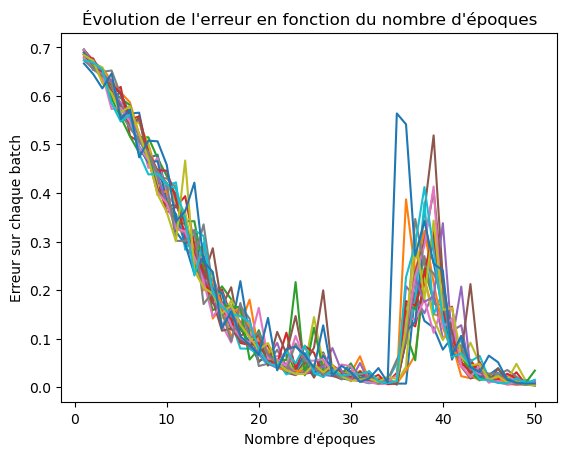

In [12]:
plt.title("Évolution de l'erreur en fonction du nombre d'époques")
plt.plot(np.arange(1, 51, 1), losses)
plt.xlabel("Nombre d'époques")
plt.ylabel("Erreur sur chaque batch")

loss, accuracy, _ = validate(model, overfit_loader)
print(f"L'erreur moyenne du modèle entraîné sur la distribution d'entraînement est de {loss:.4f} et sa précision est de {accuracy:.2f}.")

**Q6**. Que pouvez-vous conclure sur les capacités d'apprentissage de votre modèle?

Le modèle réussi à converger vers une excellente précision. On remarque que l'erreur du modèle sur chaque batch fluctue grandement entre chaque itération, mais qu'elle finit par tendre vers zéro après 40 générations. De plus, la précision de 100% laisse envisager que le modèle s'est surentraîné sur les données fournies, et qu'il risque d'avoir apris à identifier les images sur lesquelles il s'est entraîné plutôt que d'avoir développer une intuition sur la présence d'une tumeur dans une biobsie mammaire.

**Q7**. Quelles sont les performances de ce modèle sur-entraîné sur l'ensemble de validation?

In [13]:
loss_sur, accuracy_sur, _ = validate(model, val_loader)
print(f"L'erreur moyenne du modèle sur-entraîné sur la distribution de validation est de {loss_sur:.4f} et sa précision est de {accuracy_sur:.2f}.")


L'erreur moyenne du modèle sur-entraîné sur la distribution de validation est de 1.0744 et sa précision est de 0.74.


On remarque que comme la proportion des deux classes parmis l'ensemble de validation est de 0.50, un modèle qui classifierait toutes les images comme étant un résultat positif aurait une précision de 0.50. Ainsi, celle du modèle généré n'est pas très bonne, tel que discuté à la question 6. Ce résultat est aussi confirmé par la grande erreur moyenne du modèle sur la distribution de validation.

## Variation du taux d'apprentissage

<span style="color:red">**Attention !** Pour la suite du TP on veut utiliser le plus d'images possible du dataset, mais en faisant un compromis avec le temps d'entraînement. Le temps que vous écriviez votre code et que vous le testiez, vous pouvez utiliser une petite proportion des données. Toutefois pour le rendu final, utilisez **un minimum de 25%** des données d'entraînement. Vous devrez créer de nouveaux dataloaders avec la proportion appropriée.</span>

Un des paramètres essentiels dans l'entraînement d'un modèle est le taux d'apprentissage (*learning rate*), qui détermine la taille du pas qu'on prend lors de la descente de gradient pour optimiser un modèle.

**Q8**. Entraînez 3 modèles avec respectivement un *learning rate* de `1`, `1e-3`, et `1e-6`. Assurez-vous de laisser l'argument `pretrained` de la fonction `get_model_and_optimizer` à sa valeur par défaut de `False`. Durant l'entraînement de chaque modèle, faites une sauvegarde du modèle lorsque vous obtenez la meilleure accuracy. Affichez les courbes d'évolution de votre *loss* d'entraînement (par batch), et de votre *loss* et *accuracy* de validation (par époque).

Pour sauvegarder un modèle, vous pouvez utiliser la syntaxe suivante:
```py
torch.save(model.state_dict(), f"mon_modèle.pt")
```
La méthode `state_dict()` d'un modèle PyTorch retourne un `dict` qui contient les poids du modèle, tandis que la fonction `torch.save` permet de sauvegarder un tenseur (ou une collection de tenseurs comme un `dict`) sous un nom de fichier donné.

Pour charger un modèle à partir d'une sauvegarde, il faut d'abord créer un modèle identique, charger le `dict` des poids depuis le fichier, puis charger le `dict` de poids dans le modèle.
```py
saved_model = get_model_and_optimizer(pretrained=False)[0]
saved_state_dict = torch.load("mon_modèle.pt", map_location="cpu")
saved_model.load_state_dict(saved_state_dict)
```

In [16]:
train_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size=128, train_subset=0.25)


Epoque: 100%|██████████| 10/10 [14:58<00:00, 89.88s/it]


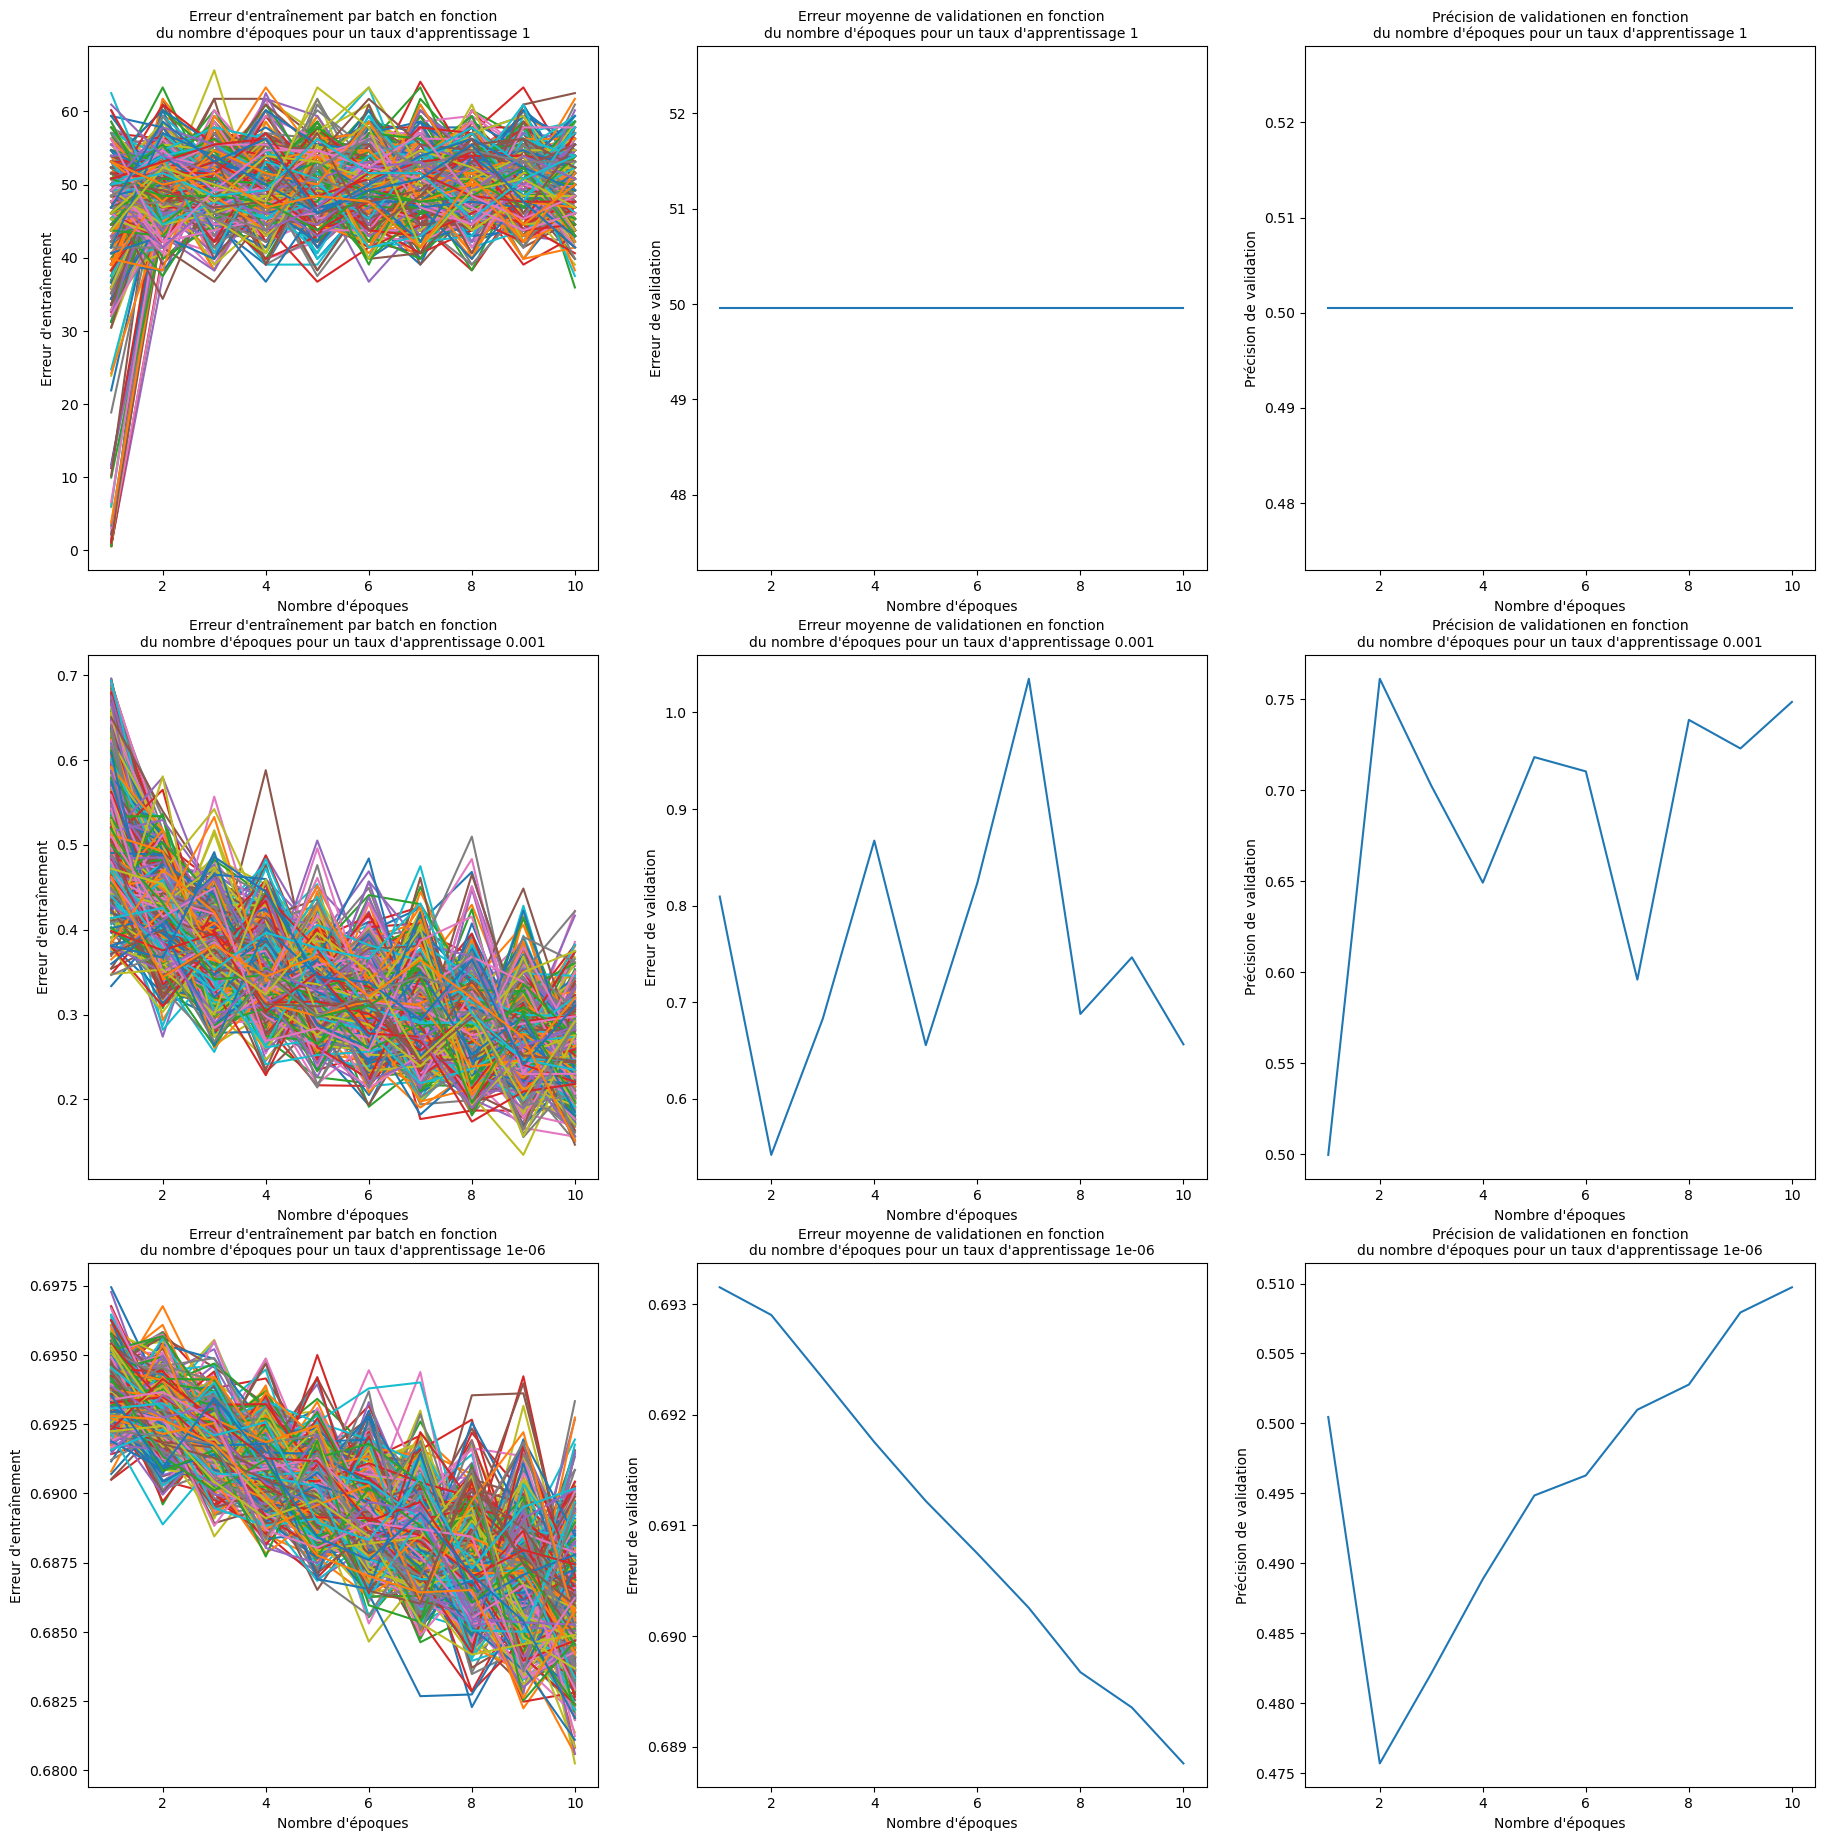

In [17]:
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(18.0, 18.0)
fig.tight_layout(w_pad=4.0, h_pad=4.0)

for i, lr in enumerate([1, 1e-3, 1e-6]):
    model, optimizer = get_model_and_optimizer(lr=lr)

    losses = []
    accuracies = []
    val_losses = []

    ref_accuracy = 0
    epoques = np.arange(1, 11, 1)

    for j in tqdm(range(10), desc="Epoque"):
        losses.append(train_epoch(model, train_loader, optimizer))

        loss, accuracy, _ = validate(model, val_loader)
        val_losses.append(loss)
        accuracies.append(accuracy)

        if accuracy > ref_accuracy:
            ref_accuracy = accuracy
            best_model_parameters = model.state_dict()
    
    axes[i][0].set_title(f"Erreur d'entraînement par batch en fonction\ndu nombre d'époques pour un taux d'apprentissage {lr}", fontdict={'fontsize': 10})
    axes[i][0].plot(epoques, losses)
    axes[i][0].set_xlabel("Nombre d'époques", fontdict={'fontsize': 10})
    axes[i][0].set_ylabel("Erreur d'entraînement", fontdict={'fontsize': 10})
    axes[i][1].set_title(f"Erreur moyenne de validationen en fonction\ndu nombre d'époques pour un taux d'apprentissage {lr}", fontdict={'fontsize': 10})
    axes[i][1].plot(epoques, val_losses)
    axes[i][1].set_xlabel("Nombre d'époques", fontdict={'fontsize': 10})
    axes[i][1].set_ylabel("Erreur de validation", fontdict={'fontsize': 10})
    axes[i][2].set_title(f"Précision de validationen en fonction\ndu nombre d'époques pour un taux d'apprentissage {lr}", fontdict={'fontsize': 10})
    axes[i][2].plot(epoques, accuracies)
    axes[i][2].set_xlabel("Nombre d'époques", fontdict={'fontsize': 10})
    axes[i][2].set_ylabel("Précision de validation", fontdict={'fontsize': 10})
    torch.save(best_model_parameters, f"meilleur_modele_{lr}.pt")

**Q9**. Que pouvez-vous conclure sur l'impact du taux d'apprentissage sur l'entraînement de votre modèle? Quel est le meilleur taux d'apprentissage pour ce problème?


En comparant les trois graphiques de l'erreur d'entraînement, on remarque qu'un trop grand learning rate empêche le modèle de converger vers un minimum local. En effet, le pas utilisé dans la méthode de la descente du gradient est trop grand pour pouvoir trouver un minimum. À l'inverse, lorsque le learning rate est trop bas, la convergence du modèle est vraiment trop lente, si bien que l'erreur d'entraînement ne varie quasiment pas après 10 époques. Ainsi, le meilleur taux d'apprentissage pour ce problème est de 1e-3.

**Q10**. Comparez votre meilleur modèle avec celui qu'on a sur-entraîné plus tôt avec le sous-ensemble de 1%. Comment expliquez-vous les différences de performance ?

En comparant la précision des deux modèles, on remarque que le modèle entraîné sur 25% des images est meilleur que celui entraîné sur seulement 1%. En effet, il atteint une meilleur précision que celui de la question 7 après seulement 10 époques. Les différences de performance observées sont liés au bassin d'images utilisées. Plus ce bassin est grand, plus le modèle peut généraliser l'ajustement de ces paramètres et ainsi pouvoir mieux performer lorsqu'il est présenté à un nouvel ensemble de données.

## Apprentissage par transfert
Une technique standard pour améliorer les performances d'un modèle est d'utiliser l'apprentissage par transfert (*transfer learning*) où on utilise un modèle qui a préalablement été entraîné sur une grande quantité de données à résoudre une tâche connexe à la nôtre. On procède à un affinage (*finetuning*) de ce modèle sur des nouvelles données pour le spécialiser sur une nouvelle tâche.

**Q11**. Étant données les différences marquées entre les caractéristiques des images d'ImageNet (des chats, des chiens, des autobus, des spatules, etc.) et les images histologiques (des cellules colorées), pensez-vous qu'utiliser un modèle pré-entraîné sur ImageNet va aider vos performances de classification? Expliquez votre raisonnement.


Oui, utiliser ce modèle sera utile, même si la tâche des deux modèles n'est pas tout à fait identique. Le modèle d'ImageNet permet de différencier des images entre elles à partir de ce qu'elles représentent et on a besoin d'un modèle qui différencie les images histologiques. Les apprentissages acquis dans le modèle d'ImageNet peuvent être transférés dans notre modèle, puisque les tâches ont un minimum de similitudes entre les deux.

**Q12**. Affinez pendant au moins 10 époques un modèle pré-entraîné. Créez le en utilisant l'argument `pretrained=True`. Utilisez le *learning rate* qui vous a donné les meilleures performances à l'exercice précédent. Durant l'entraînement du modèle, faites une sauvegarde du modèle lorsque vous obtenez la meilleure accuracy. Affichez les courbes d'évolution de votre *loss* d'entraînement, et de votre *loss* et *accuracy* de validation.

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to C:\Users\sobeac/.cache\torch\hub\checkpoints\mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:01<00:00, 11.6MB/s]
Epoque: 100%|██████████| 10/10 [14:15<00:00, 85.57s/it]


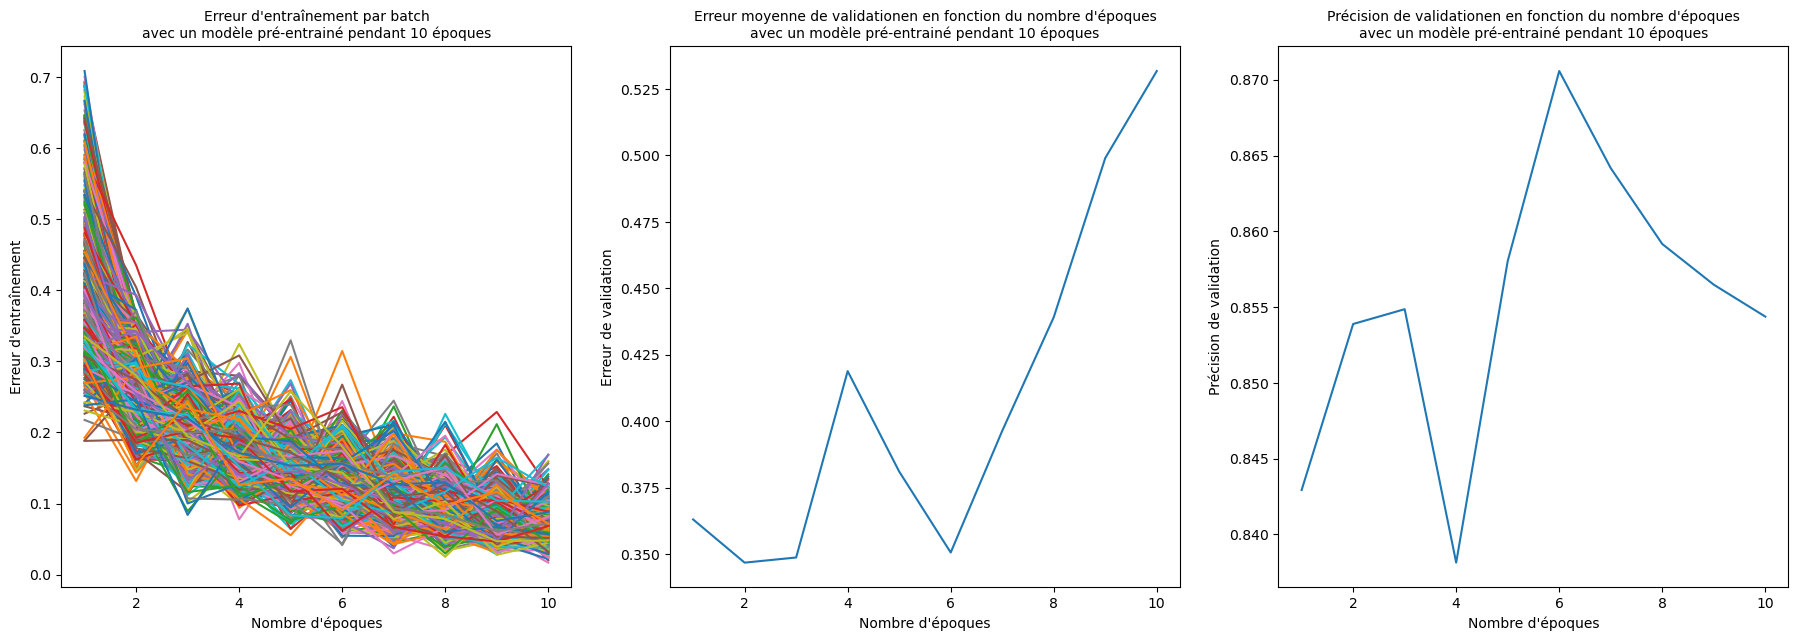

In [18]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.0, 6.0)
fig.tight_layout(w_pad=4.0, h_pad=4.0)

model, optimizer = get_model_and_optimizer(lr=1e-3, pretrained=True)

losses = []
accuracies = []
val_losses = []

ref_accuracy = 0
epoques = np.arange(1, 11, 1)

for j in tqdm(range(10), desc="Epoque"):
    losses.append(train_epoch(model, train_loader, optimizer))

    loss, accuracy, _ = validate(model, val_loader)
    val_losses.append(loss)
    accuracies.append(accuracy)

    if accuracy > ref_accuracy:
        ref_accuracy = accuracy
        best_model_parameters = model.state_dict()

axes[0].set_title("Erreur d'entraînement par batch\navec un modèle pré-entrainé pendant 10 époques", fontdict={'fontsize': 10})
axes[0].plot(epoques, losses)
axes[0].set_xlabel("Nombre d'époques", fontdict={'fontsize': 10})
axes[0].set_ylabel("Erreur d'entraînement", fontdict={'fontsize': 10})
axes[1].set_title("Erreur moyenne de validationen en fonction du nombre d'époques\navec un modèle pré-entrainé pendant 10 époques", fontdict={'fontsize': 10})
axes[1].plot(epoques, val_losses)
axes[1].set_xlabel("Nombre d'époques", fontdict={'fontsize': 10})
axes[1].set_ylabel("Erreur de validation", fontdict={'fontsize': 10})
axes[2].set_title("Précision de validationen en fonction du nombre d'époques\navec un modèle pré-entrainé pendant 10 époques", fontdict={'fontsize': 10})
axes[2].plot(epoques, accuracies)
axes[2].set_xlabel("Nombre d'époques", fontdict={'fontsize': 10})
axes[2].set_ylabel("Précision de validation", fontdict={'fontsize': 10})
torch.save(best_model_parameters, "meilleur_modele_pretrained.pt")

**Q13**. Comparez les performances de votre modèle pré-entraîné avec celles de votre modèle non pré-entraîné. Qu'en concluez-vous?

En comparant les performances des deux modèles, on remarque que le modèle pré-entraîné est plus précis que le modèle non pré-entraîné après le même nombre d'époques. En effet, il obtient une précision maximale de 0.87, ce qui est nettement supérieur avec ce qui avait été obtenu sans le pré-entraînement. Ce résultat est cohérent avec la notion de transfert de l'apprentissage tel que décrit à la question 11.

## Évaluation finale
Jusqu'à présent on n'a évalué le modèle que sur le sous-ensemble de validation. Pour obtenir une évaluation finale de notre modèle, on doit l'évaluer sur l'ensemble de test.

**Q14**. Évaluez votre meilleur modèle sur l'ensemble de test. Affichez la *loss* et l'accuracy finale.

In [20]:
saved_model = get_model_and_optimizer(pretrained=False)[0]
saved_state_dict = torch.load("meilleur_modele_pretrained.pt", map_location="cpu")
saved_model.load_state_dict(saved_state_dict)
loss_final, accuracy_final, preds_final=validate(saved_model,test_loader)
print(f"L'erreur finale est de {loss_final:.4f} et la précision finale est de {accuracy_final:.2f}.")

C:\Users\sobeac\AppData\Local\Temp\ipykernel_4048\2990380434.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load("meilleur_modele_pretrained.pt

L'erreur finale est de 0.6005 et la précision finale est de 0.83.


**Q15**. Commentez les performances de votre modèle sur l'ensemble de test et comparez-les à celles obtenues sur l'ensemble de validation.

Les performances du modèle sur l'ensemble de test démontre clairement que le modèle a réussi à développer une certaine compréhension de la tâche, car il réussi à donner un diagnostique satisfaisant même lorsqu'il est présenté à un nouvel ensemble de données. Par contre, sa précision est légèrement inférieur à celle obtenue avec l'ensemble de validation.

**Q16**. Pourquoi est-il important de maintenir un ensemble de test séparé de l'ensemble de validation? Que se passerait-il si on n'avait que 2 ensembles (entraînement et test) plutôt que 3 (entraînement, validation, test)?

Si nous utilisons uniquement un ensemble de test sans un ensemble de validation, le choix et l'optimisation des hyperparamètres devront se faire directement sur l'ensemble  de tests. Cela risque de provoquer une erreur dans le traitement des données, c'est-à-dire que le modèle crée sera indirectement influencé par les données de tests durant sa phase de développement. Le modèle pourrait s'adapter aux particularités de l'ensemble de test, ce qui fausserait l'évaluation de ses performances réelles sur de nouvelles données, en donnant une impression exagérée de sa capacité à généraliser ces apprentissages reçus.

**Q17**. Au sein de l'ensemble de test, identifiez
- Un exemple d'un vrai positif (une image cancéreuse correctement identifiée comme cancéreuse).
- Un exemple d'un faux positif (une image non-cancéreuse incorrectement identifiée comme cancéreuse).
- Un exemple d'un faux négatif (une image cancéreuse incorrectement identifiée comme non-cancéreuse).
- Un exemple d'un vrai négatif (une image non-cancéreuse correctement identifiée comme non-cancéreuse).

Affichez chaque image, son label, la prédiction de votre modèle, et l'index de l'exemple.

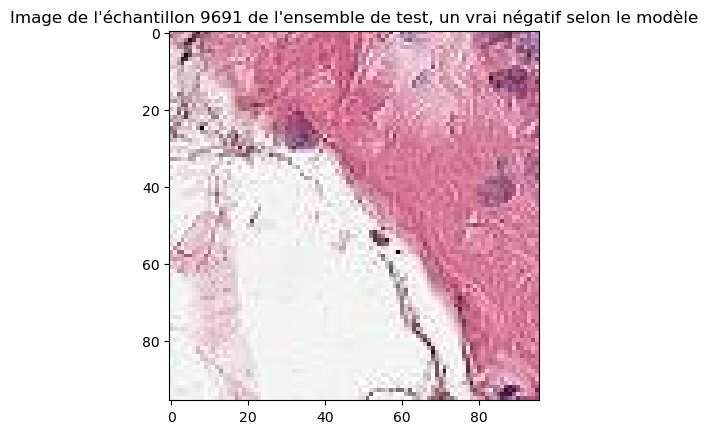

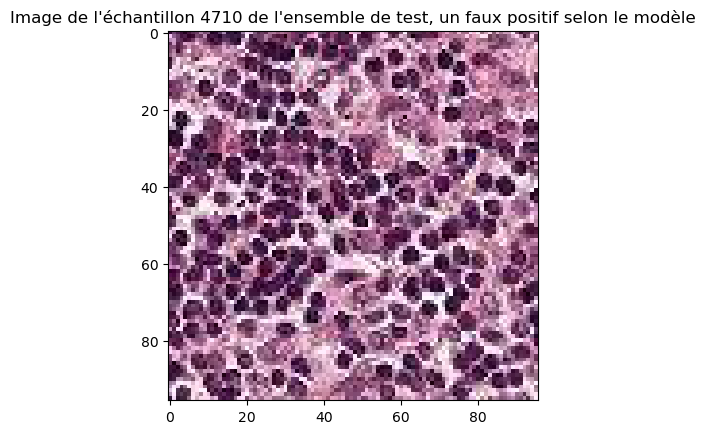

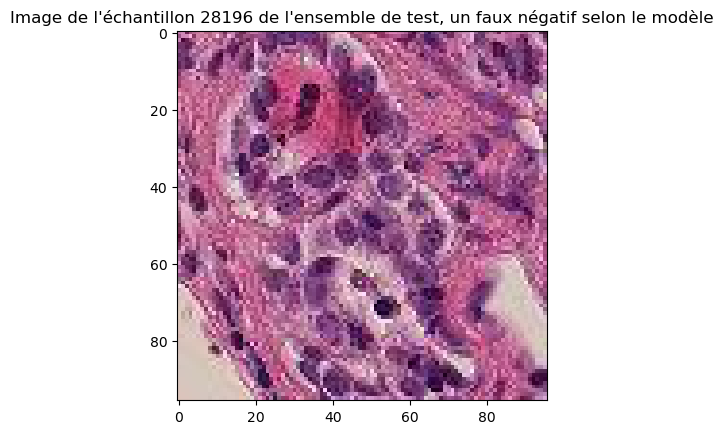

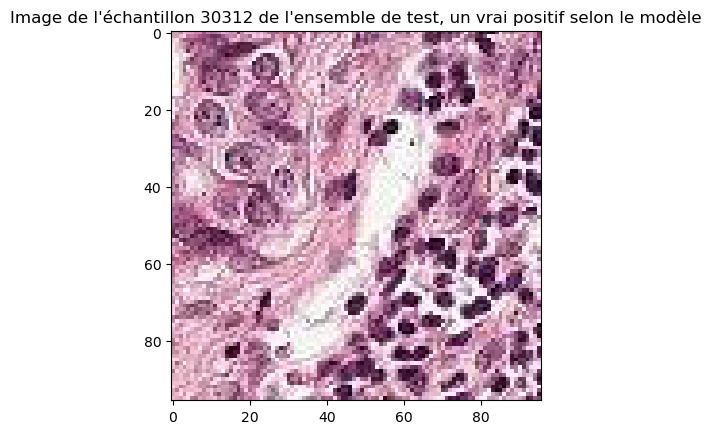

In [33]:
ref_labels = [label for label in dataset["test"]["label"]]
ref_images = [img for img in dataset["test"]["image"]]

indexes_by_test_results = [[[], []], [[], []]]
for index, labels in enumerate(zip(ref_labels, preds_final)):
    indexes_by_test_results[labels[0]][labels[1]].append(index)

echantillon_TN_index = np.random.choice(indexes_by_test_results[0][0], size=1, replace=False).tolist()[0]
echantillon_FP_index = np.random.choice(indexes_by_test_results[0][1], size=1, replace=False).tolist()[0]
echantillon_FN_index = np.random.choice(indexes_by_test_results[1][0], size=1, replace=False).tolist()[0]
echantillon_TP_index = np.random.choice(indexes_by_test_results[1][1], size=1, replace=False).tolist()[0]

echantillons = [(echantillon_TN_index, "vrai négatif"), (echantillon_FP_index, "faux positif"), (echantillon_FN_index, "faux négatif"), (echantillon_TP_index, "vrai positif")]

for index, state in echantillons:
    fig, ax = plt.subplots(1,1)

    ax.set_title(f"Image de l'échantillon {index} de l'ensemble de test, un {state} selon le modèle")
    ax.imshow(ref_images[index])

**Q18**. Au vu des performances de votre meilleur modèle sur les données de test, seriez-vous à l'aise d'intégrer ce modèle dans des protocoles cliniques d'histopathologie?

La précision de ce modèle n'est toujours pas très satisfaisante. Ainsi, nous devons faire attention avant d'enlever le jugement complet d'un médecin dans la prise de décision du diagnostique du patient. Par contre, il pourrait être utilisé afin d'accélérer le processus de classement de priorités des patients, comme il permet de faire un premier tris beaucoup plus rapidement qu'un humain pourrait le faire.